In [15]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle
import random
import itertools
import collections
import re
from tqdm import tqdm
import torch
import string
import json
from nltk import word_tokenize
from nltk.util import ngrams
import statistics

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "sans-serif"
import seaborn as sns

tqdm.pandas()
pd.set_option('max_colwidth', 100)

from ast import literal_eval

from transformers import AutoTokenizer, AutoModelForQuestionAnswering


In [16]:
# import sys
# !{sys.executable} -m pip install statsmodels

import pandas as pd
pd.read_csv("../IDU_PAPER/result_fig/queryGroup_distribution_nov.csv")

count                   queryGroups
0    450         active/historical use
1    295                    drug names
2    195              existence of IDU
3     65   risky needle-using behavior
4     55                      last use
5     20          visible signs of IDU
6     20              frequency of use
7      5                  skin popping
8      5  harm reduction interventions

In [17]:
pd.read_csv("../IDU_PAPER/result_fig/queryGroup_distribution_feb.csv")

count                  queryGroups
0    885        active/historical use
1    445                   drug names
2    285                     last use
3    255             existence of IDU
4     45                 skin popping
5     30  risky needle-using behavior
6     30             frequency of use
7     10         visible signs of IDU

In [18]:
map_cat = {
           'active/historical':'active/historical use',
           'drug names':'drug names',
           'existence of idu':'existence of IDU',
           'last use':'last use',
           'occasional/daily':'frequency of use',
           'needle sharing':'risky needle-using behavior',
           'skin popping':'skin popping',
           'evidence track marks': 'visible signs of IDU', 
           'ssp':'harm reduction interventions',
}


In [19]:
model = 'clinicalbert'
m = AutoTokenizer.from_pretrained(
    f"/mnt/pfb_rvdata/mahbub/pre_trained_models/{model}/")

def count_tokens(text):
    tokens = m.tokenize(text)
    return len(tokens)

def count_words(text):
    return len(text.split())


In [20]:
df_jan = pd.read_csv('/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/train_test_jan_postvalidation.csv')
df_feb = pd.read_csv('/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/test_feb_postvalidation.csv')
df_nov = pd.read_csv('/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/test_nov_postvalidation.csv')

print(df_jan.shape)
print(df_feb.shape)
print(df_nov.shape)

(17410, 9)
(1985, 8)
(1110, 8)


# Data Stats

In [21]:
df_jan['CONTEXT_LEN_WORDS'] = df_jan['CONTEXT'].progress_apply(count_words)
df_feb['CONTEXT_LEN_WORDS'] = df_feb['CONTEXT'].progress_apply(count_words) 
df_nov['CONTEXT_LEN_WORDS'] = df_nov['CONTEXT'].progress_apply(count_words) 

df_jan['QUESTION_LEN_WORDS'] = df_jan['QUESTION'].progress_apply(count_words)
df_feb['QUESTION_LEN_WORDS'] = df_feb['QUESTION'].progress_apply(count_words) 
df_nov['QUESTION_LEN_WORDS'] = df_nov['QUESTION'].progress_apply(count_words) 


100%|██████████████████████████████████████████████████| 1110/1110 [00:00<00:00, 758995.34it/s]


In [22]:
df_jan[['VALIDATED_ANSWER']].sample(10) #.iloc[9614].values

VALIDATED_ANSWER
15564  was most recently using in/iv heroin andoxycodone with occasional illicit methadone 70mg. he rep...
7013                                                                                    denied recent ivdu
13653                                                                           previous ivdu 30 years ago
14932   used heroin in the lue on day prior to admission and stated both ulcers started after using heroin
15839                            previous hx of iv heroin usage, quit 3 years ago. currently on methadone.
4849                                                                                daily use of iv heroin
5490                                        long history of iv drug use including methamphetamines, heroin
8022                                                jan 5,2022 due to an accidental over dose of iv heroin
11491                                                                        previously ivdu 15+ years ago
13698                                                                   ivdu (heroin, at methadone clinic)

In [23]:
train_jan = json.load(open("/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/train_jan.json"))
val_jan   = json.load(open("/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/val_jan.json"))
test_jan  = json.load(open("/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/test_jan.json"))
test_feb  = json.load(open("/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/test_feb.json"))
test_nov  = json.load(open("/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/test_nov.json"))

In [24]:
len(train_jan['data'][0]['paragraphs'])

assert len(df_jan[df_jan['SPLIT']=='TRAIN']) == len(train_jan['data'])
assert len(df_jan[df_jan['SPLIT']=='VAL']) == len(val_jan['data'])
assert len(df_jan[df_jan['SPLIT']=='TEST']) == len(test_jan['data'])
assert len(df_feb) == len(test_feb['data'])
assert len(df_nov) == len(test_nov['data'])

def get_answerls_from_json(json_file):
    answer_list = []
    for x in json_file['data']:
        assert len(x) == 2
        assert len(x['paragraphs']) == 1
        para = x['paragraphs'][0]
        assert len(para['qas']) == 1
        answer = para['qas'][0]['answers']
        assert len(answer) == 1
        answer = answer[0]['text']
        answer_list.append(answer)
    print(len(answer_list))
    return answer_list

train_jan_answerls = get_answerls_from_json(train_jan)
val_jan_answerls   = get_answerls_from_json(val_jan)
test_jan_answerls  = get_answerls_from_json(test_jan)
test_feb_answerls  = get_answerls_from_json(test_feb)
test_nov_answerls  = get_answerls_from_json(test_nov)

12945
1230
3235
1985
1110


In [25]:
len(train_jan_answerls+val_jan_answerls+test_jan_answerls)

17410

In [26]:
jan_ansLen = [count_words(ans) for ans in train_jan_answerls+val_jan_answerls+test_jan_answerls]
feb_ansLen = [count_words(ans) for ans in test_feb_answerls]
nov_ansLen = [count_words(ans) for ans in test_nov_answerls]


In [27]:
max([count_words(x) for x in test_jan_answerls])

56

In [28]:
# print("Mean: ", np.mean(df_jan['QUESTION_LEN_WORDS']))
# print("Median: ", np.median(df_jan['QUESTION_LEN_WORDS']))
# print("Max: ", np.max(df_jan['QUESTION_LEN_WORDS']))

# print("Mean: ", np.mean(jan_ansLen))
# print("Median: ", np.median(jan_ansLen))
# print("Max: ", np.max(jan_ansLen))

In [29]:
# statistics.mean(jan_ansLen)

In [30]:
# print("Mean: ", np.mean(df_feb['QUESTION_LEN_WORDS']))
# print("Median: ", np.median(df_feb['QUESTION_LEN_WORDS']))
# print("Max: ", np.max(df_feb['QUESTION_LEN_WORDS']))

# print("Mean: ", np.mean(feb_ansLen))
# print("Median: ", np.median(feb_ansLen))
# print("Max: ", np.max(feb_ansLen))

In [31]:
# print("Mean: ", np.mean(df_nov['QUESTION_LEN_WORDS']))
# print("Median: ", np.median(df_nov['QUESTION_LEN_WORDS']))
# print("Max: ", np.max(df_nov['QUESTION_LEN_WORDS']))

# print("Mean: ", np.mean(nov_ansLen))
# print("Median: ", np.median(nov_ansLen))
# print("Max: ", np.max(nov_ansLen))

In [32]:
# len(set(df_nov['TIUDocumentSID'])), len(df_nov), len(set(df_nov['PatientICN']))

# Plotting Functions

In [107]:
colors = ['#e69d00', '#56b3e9', '#009e74', 
          '#f0e442', '#0071b2', '#808080',
          '#d55c00', '#cc79a7', '#000000']
map_cat = {
           'active/historical':'active/historical use',
           'drug names':'drug names',
           'existence of idu':'existence of IDU',
           'last use':'last use',
           'occasional/daily':'frequency of use',
           'needle sharing':'risky needle-using behavior',
           'skin popping':'skin popping',
           'evidence track marks': 'visible signs of IDU', 
           'ssp':'harm reduction interventions',
}

cat_to_color = dict(zip(map_cat.values(), colors))

def plot_categories_dist(df, month):
    
    df['CAT'] = df['CATEGORIES'].map(map_cat)

#     random.seed(1)
#     colors = random.sample(sns.color_palette('pastel'),9)
    
    labels = [x for x in df['CAT'].value_counts().keys()]
    
    colors = [cat_to_color[k] for k in df['CAT'].value_counts().keys()]
    
    fig,ax = plt.subplots(figsize=(8,22))
    if month=='feb':
        explode = (0.01,0.01,0.02,0.03,0.04,0.05,0.2,0.3)
    else:
        explode = (0.01,0.01,0.02,0.03,0.04,0.05,0.2,0.3, 0.5)
        
    _wedges, labels, percentages = plt.pie(df['CAT'].value_counts().values,
            labels = labels,
            explode=explode,
            colors=colors,
            autopct='%1.2f%%',
#             shadow=False,
            startangle=45,
            textprops={'fontsize':12}
                                    )
    
    for label, percentage in zip(labels, percentages):
        perc = float(percentage.get_text()[:-1])
        if perc < 1:
            perc_text = '<1%'
        else:
            perc_text = percentage.get_text()
        label.set_text(label.get_text() + ' ' + f'({perc_text})')
        percentage.remove()
    
    # plt.xticks(size=25)
    
    fig.savefig(f"/mnt/pfb_rvdata/mahbub/EGRESS/FIGURES/pie_{month}.svg",
            format='svg', dpi=600,
            bbox_inches='tight'
           )
    plt.show()


def plot_binned_score_len(df, column_name, bins, xlab):
    df['COUNT'] = [1]*len(df)
    col = ['EM','F1','Precision','Recall',
           'COUNT', column_name]
    colors= ['#e69f00', '#000000']
    
    df_binned     = df.groupby(pd.cut(df[column_name],bins=bins))[col].mean()
    df_binned_sum = df.groupby(pd.cut(df[column_name],bins=bins))[col].sum()

    assert (df_binned.index == df_binned_sum.index).all()
    assert df_binned.shape == df_binned_sum.shape
    
    df_binned.dropna(inplace=True)
    df_binned_sum.dropna(inplace=True)
    df_binned_sum = df_binned_sum[df_binned_sum['COUNT']!=0]
    
    assert df_binned.shape == df_binned_sum.shape

    fig,ax = plt.subplots(figsize=(9,8))
    
    plt.plot(range(df_binned.shape[0]),df_binned['EM'].values, '*:',
             color = colors[0], label = 'F1 (Strict)')
    plt.plot(range(df_binned.shape[0]),df_binned['F1'].values, 'v--',
             color = colors[0], label = 'F1 (Relaxed)')
    plt.plot(range(df_binned.shape[0]),df_binned['Recall'].values, 'o-.',
             color = colors[0], label = 'Recall (Relaxed)')
    plt.plot(range(df_binned.shape[0]),df_binned['Precision'].values, 'X-',
             color = colors[0], label = 'Precision (Relaxed)')
    
    plt.legend(loc = 'upper right', prop = {'size':12})
#     best
# 	upper right
# 	upper left
# 	lower left
# 	lower right
# 	right
# 	center left
# 	center right
# 	lower center
# 	upper center
# 	center
    plt.xticks(range(df_binned.shape[0]), list(df_binned.index),
               fontsize=13)
    plt.yticks(fontsize=13, color=colors[0])
    
    plt.ylim(0., 1.1)
    plt.xlabel(f'\nbins of {xlab}', fontsize=15)
    plt.ylabel(f'performance score\n', fontsize=15, color=colors[1], alpha=1)
    
    ax.tick_params(direction='out', bottom=True, left=True,
                   length=5, width=1)
    
    ax2 = ax.twinx()
#     df_binned_sum['COUNT_log'] = np.log10(df_binned_sum['COUNT'])
    ax2.bar(range(df_binned.shape[0]),df_binned_sum['COUNT'].values,
            hatch = '///', edgecolor='black',
            alpha=.4, width=.4,color=colors[1],
           )
    plt.ylabel(f'\ncount', fontsize=15, color=colors[1], alpha=1)
#     ax2.set_yscale("log")
    plt.ylim(0, 6000)
#     plt.yticks(range(0, max(df_binned_sum['COUNT'].values)+2000, 2000))
    plt.yticks(fontsize=13, color=colors[1])
    plt.show()

    print(df_binned_sum['COUNT'].values)
    
    return df_binned


import scipy
from statsmodels.stats.proportion import proportion_confint

def get_confidence_score_binary(df, metric):
    data_cs = df[metric].values.tolist()
    x = sum([1 for y in data_cs if y==1])
    n = len(data_cs)
    c = proportion_confint(count=x, nobs=n, alpha=0.05,
                           method="binom_test"
                          )
    c1 = c[0]
    c2 = c[1]
        
    return "{0:.2f}".format(c1*100), "{0:.2f}".format(c2*100)


def get_confidence_score_nonbinary(df, metric):
    x = df[metric].values
    m = x.mean()
    s = x.std()
    dof = len(x)-1
    confidence = 0.95

    t_crit = np.abs(scipy.stats.t.ppf((1-confidence)/2, dof))
    c1 = m-s*t_crit/np.sqrt(len(x))
    c2 = m+s*t_crit/np.sqrt(len(x))

    return "{0:.2f}".format(c1*100), "{0:.2f}".format(c2*100)


In [109]:
# plot_categories_dist(df_nov, 'nov')

In [111]:
# plot_categories_dist(df_jan, 'jan')

In [113]:
# plot_categories_dist(df_feb, 'feb')

In [78]:
colors = ['#e69d00', '#56b3e9', '#009e74', 
          '#f0e442', '#0071b2', '#808080',
          '#d55c00', '#cc79a7', '#000000']
map_cat = {
           'active/historical':'active/historical use',
           'drug names':'drug names',
           'existence of idu':'existence of IDU',
           'last use':'last use',
           'occasional/daily':'frequency of use',
           'needle sharing':'risky needle-using behavior',
           'skin popping':'skin popping',
           'evidence track marks': 'visible signs of IDU', 
           'ssp':'harm reduction interventions',
}

cat_to_color = dict(zip(map_cat.values(), colors))

def plot_categories_dist(ax, which_plot, df, month):
    
    df['CAT'] = df['CATEGORIES'].map(map_cat)

#     random.seed(1)
#     colors = random.sample(sns.color_palette('pastel'),9)
    
    labels = [x for x in df['CAT'].value_counts().keys()]
    
    colors = [cat_to_color[k] for k in df['CAT'].value_counts().keys()]
    
#     fig,ax = plt.subplots(figsize=(8,22))
    if month=='feb':
        explode = (0.01,0.01,0.02,0.03,0.04,0.05,0.2,0.3)
    else:
        explode = (0.01,0.01,0.02,0.03,0.04,0.05,0.2,0.3, 0.5)
        
    _wedges, labels, percentages = plt.pie(df['CAT'].value_counts().values,
            labels = labels,
            explode=explode,
            colors=colors,
            autopct='%1.2f%%',
#             shadow=False,
            startangle=45,
#             textprops={'fontsize':12}
                                    )
    
    for label, percentage in zip(labels, percentages):
        perc = float(percentage.get_text()[:-1])
        if perc < 1:
            perc_text = '<1%'
        else:
            perc_text = percentage.get_text()
        label.set_text(label.get_text() + ' ' + f'({perc_text})')
        percentage.remove()
    # plt.xticks(size=25)
    

    ax.text(-0.2, 1.1, which_plot, ha='left', va='top', transform=ax.transAxes, fontsize=20, weight='bold')


In [79]:
# dftosave = pd.DataFrame(df_nov['CAT'].value_counts())
# dftosave.reset_index(inplace=True)
# dftosave['queryGroups'] = dftosave['CAT']
# dftosave.drop(['CAT'], axis=1, inplace=True)
# dftosave.to_csv('../IDU_PAPER/result_fig/queryGroup_distribution_nov.csv', index=False)


<Figure size 640x480 with 0 Axes>

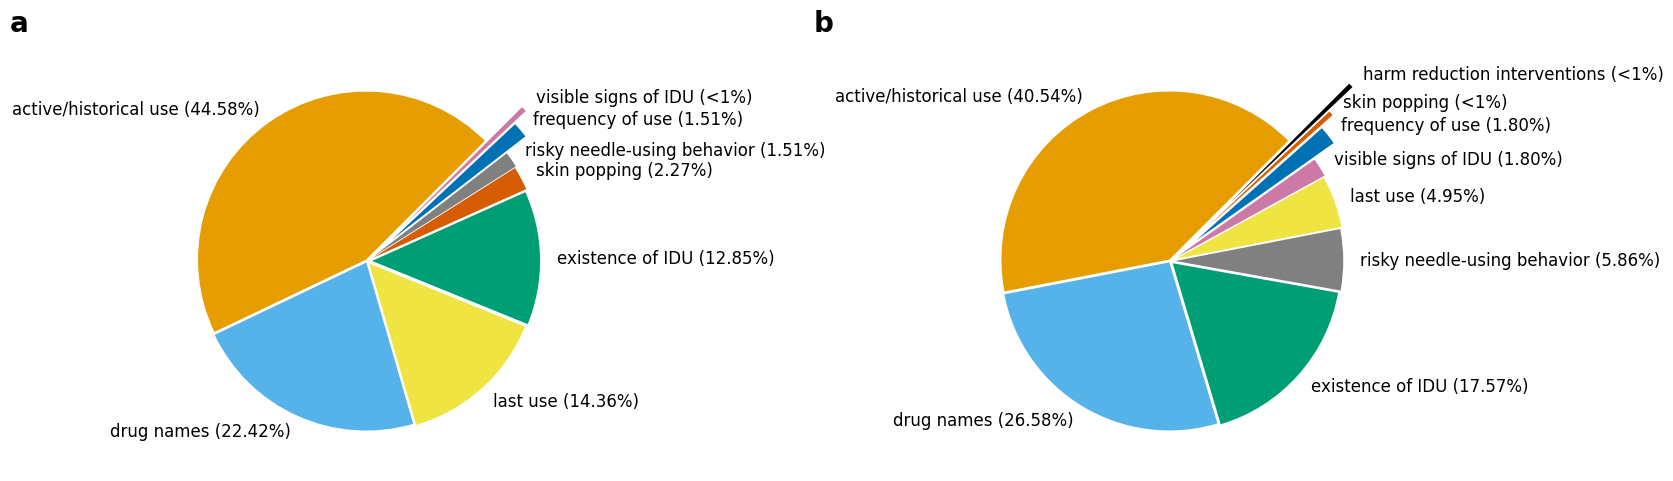

In [105]:
plt.subplots_adjust(hspace=1, wspace=5)

fig = plt.figure(figsize=(19, 12))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
axes = [ax1, ax2]

    
month='feb'
df_feb['CAT'] = df_feb['CATEGORIES'].map(map_cat)

#     random.seed(1)
#     colors = random.sample(sns.color_palette('pastel'),9)

labels = [x for x in df_feb['CAT'].value_counts().keys()]

colors = [cat_to_color[k] for k in df_feb['CAT'].value_counts().keys()]

#     fig,ax = plt.subplots(figsize=(8,22))
if month=='feb':
    explode = (0.01,0.01,0.02,0.03,0.04,0.05,0.2,0.3)
else:
    explode = (0.01,0.01,0.02,0.03,0.04,0.05,0.2,0.3, 0.5)

_wedges, labels, percentages = axes[0].pie(df_feb['CAT'].value_counts().values,
        labels = labels,
        explode=explode,
        colors=colors,
        autopct='%1.2f%%',
#             shadow=False,
        startangle=45,
        textprops={'fontsize':12}
                                )

for label, percentage in zip(labels, percentages):
    perc = float(percentage.get_text()[:-1])
    if perc < 1:
        perc_text = '<1%'
    else:
        perc_text = percentage.get_text()
    label.set_text(label.get_text() + ' ' + f'({perc_text})')
    percentage.remove()
# plt.xticks(size=25)


axes[0].text(-0.35, 1.1, 'a', ha='left', va='top', transform=axes[0].transAxes, fontsize=20, weight='bold')




month='nov'
df_nov['CAT'] = df_nov['CATEGORIES'].map(map_cat)

#     random.seed(1)
#     colors = random.sample(sns.color_palette('pastel'),9)

labels = [x for x in df_nov['CAT'].value_counts().keys()]

colors = [cat_to_color[k] for k in df_nov['CAT'].value_counts().keys()]

#     fig,ax = plt.subplots(figsize=(8,22))
if month=='feb':
    explode = (0.01,0.01,0.02,0.03,0.04,0.05,0.2,0.3)
else:
    explode = (0.01,0.01,0.02,0.03,0.04,0.05,0.2,0.3, 0.5)

_wedges, labels, percentages = axes[1].pie(df_nov['CAT'].value_counts().values,
        labels = labels,
        explode=explode,
        colors=colors,
        autopct='%1.2f%%',
#             shadow=False,
        startangle=45,
        textprops={'fontsize':12}
                                )

for label, percentage in zip(labels, percentages):
    perc = float(percentage.get_text()[:-1])
    if perc < 1:
        perc_text = '<1%'
    else:
        perc_text = percentage.get_text()
    label.set_text(label.get_text() + ' ' + f'({perc_text})')
    percentage.remove()
# plt.xticks(size=25)


axes[1].text(-0.35, 1.1, 'b', ha='left', va='top', transform=axes[1].transAxes, fontsize=20, weight='bold')




# plot_categories_dist(axes[0], 'a', df_feb, 'feb')
# # plot_categories_dist(axes[1], 'b', df_nov, 'nov')

# fig.savefig(f"/mnt/pfb_rvdata/mahbub/EGRESS/FIGURES/pie_feb_nov.svg",
#         format='svg', dpi=600,
#         bbox_inches='tight'
#        )
plt.show()


In [ ]:
# col = 'CONTEXT_LEN_WORDS'
# ylab = 'context length'

# col = 'QUESTION_LEN_WORDS'
# ylab = 'question length'

col = 'GANSWER_LEN_WORDS'
ylab = 'answer length'

stat = data[col].describe()
bins = [
    stat['min']-1,
    stat['25%'],
    stat['50%'],
    stat['75%'],
    stat['max'],
    np.inf
]

# plot_binned_score_len(data, col, bins, f"{ylab} (in number of words)")

In [ ]:
def plot_multiple(column_name, ylab, xlab, ax, which_plot, rotation=0):
    
    data['COUNT'] = [1]*len(data)

    stat = data[column_name].describe()

    bins = [
        stat['min']-1,
        stat['25%'],
        stat['50%'],
        stat['75%'],
        stat['max'],
        np.inf
    ]


    col = ['EM','F1','Precision','Recall',
           'COUNT', column_name]

    ytcklbl = [round(x,1) for x in np.arange(0,1.2,0.2)]

    data_binned     = data.groupby(pd.cut(data[column_name],bins=bins))[col].mean()
    data_binned_sum = data.groupby(pd.cut(data[column_name],bins=bins))[col].sum()

    assert (data_binned.index == data_binned_sum.index).all()
    assert data_binned.shape == data_binned_sum.shape

    data_binned.dropna(inplace=True)
    data_binned_sum.dropna(inplace=True)
    data_binned_sum = data_binned_sum[data_binned_sum['COUNT']!=0]

    assert data_binned.shape == data_binned_sum.shape

    dftosave = data_binned
    dftosave['COUNT'] = data_binned_sum['COUNT']
    dftosave['Bins'] = dftosave.index.tolist()
    dftosave.drop([column_name], axis=1, inplace=True)
    dftosave.to_csv(f"../IDU_PAPER/result_fig/error_{'_'.join(ylab.split())}.csv", index=False)

    ax.plot(range(data_binned.shape[0]),data_binned['EM'].values, '*:',
             color = colors[0], label = 'F1 (Strict)')
    ax.plot(range(data_binned.shape[0]),data_binned['F1'].values, 'v--',
             color = colors[0], label = 'F1 (Relaxed)')
    ax.plot(range(data_binned.shape[0]),data_binned['Recall'].values, 'o-.',
             color = colors[0], label = 'Recall (Relaxed)')
    ax.plot(range(data_binned.shape[0]),data_binned['Precision'].values, 'X-',
             color = colors[0], label = 'Precision (Relaxed)')

    ax.legend(loc = 'upper right',
              prop = {'size':14}
             )

    ax.set_xticks(range(data_binned.shape[0]), list(data_binned.index),
               fontsize=15, rotation=rotation
                 )
    ax.set_yticks(np.arange(0,1.2,0.2), ytcklbl,
                  fontsize=15,
                  color=colors[0])

    ax.set_ylim(0., 1.1)
    ax.set_xlabel(xlab,
                  fontsize=17
                 )
    ax.set_ylabel(f'performance score',
                  fontsize=17,
                  color='#000000', alpha=1)

    ax.tick_params(direction='out', bottom=True, left=True,
                   length=5, width=1)


    ax2 = ax.twinx()
    #     data_binned_sum['COUNT_log'] = np.log10(data_binned_sum['COUNT'])
    ax2.bar(range(data_binned.shape[0]),data_binned_sum['COUNT'].values,
            hatch = '///', edgecolor='black',
            alpha=0.8, width=.4,color=colors[1],
           )
    ax2.set_ylabel(f'count',
                   fontsize=17,
                   color='#000000', alpha=1)

    ax2.set_ylim(0, 8000)
    #     plt.yticks(range(0, max(data_binned_sum['COUNT'].values)+2000, 2000))
    ax2.set_yticks(range(1000, 9000, 1000), range(1000, 9000, 1000),
                   fontsize=15,
                   color=colors[1])

    ax.text(-0.18, 1.1, which_plot, ha='left', va='top', transform=ax.transAxes, fontsize=20, weight='bold')


In [85]:
# plt.figure(figsize=(12,6))
# ax1 = plt.subplot(2,3,1)
# ax2 = plt.subplot(2,3,2)
# ax3 = plt.subplot(2,3,3)
# ax4 = plt.subplot(2,1,2)
# axes = [ax1, ax2, ax3, ax4]

In [ ]:
### fig, axes = plt.subplots(ncols=3, nrows = 2, figsize=(12,10),
#                          constrained_layout=True,
#                          gridspec_kw = {'width_ratios':[1,1,1],
#                                         'height_ratios':[3,1]
#                                        }
#                         )

plt.subplots_adjust(hspace=1, wspace=2)

colors= ['#000000', '#0072b2']

fig = plt.figure(figsize=(22, 15))

# fig = plt.figure(figsize=(17, 9))
# ax1 = plt.subplot(1,1,1)

ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,1,2)
axes = [ax1, ax2, ax3, ax4]

# plt.ion()
# fig.canvas.draw()

# for ii, ax in enumerate(axes):
#     bbox = ax.get_tightbbox(fig.canvas.get_renderer())
#     x0,y0,width, height = bbox.transformed(fig.transFigure.inverted()).bounds
    
#     xpad = 0.007 * width
#     ypad = 0.007 * height
    
#     fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad),
#                                  width+1.1*xpad, height+1.1*ypad,
#                                  edgecolor='k', linewidth=.5,
#                                  fill=False))
    
#################################################################################################
ax = axes[0]

column_name = 'CONTEXT_LEN_WORDS'
ylab = 'context length'
which_plot = 'a'

xlab = f'bins of {ylab} (in number of words)'

plot_multiple(column_name, ylab, xlab, ax, which_plot,rotation=10)

##################################################################################################
ax = axes[1]

column_name = 'QUESTION_LEN_WORDS'
ylab = 'question length'
which_plot = 'b'

xlab = f'\nbins of {ylab} (in number of words)'

plot_multiple(column_name, ylab, xlab, ax, which_plot,rotation=0)

##################################################################################################
ax = axes[2]

column_name = 'GANSWER_LEN_WORDS'
ylab = 'answer length'
which_plot = 'c'

xlab = f'\nbins of {ylab} (in number of words)'

plot_multiple(column_name, ylab, xlab, ax, which_plot,rotation=0)

##################################################################################################
ax = axes[3]

ax.plot(
    range(len(df_cat_final)), df_cat_final['EM'].values,
    '*', 
    markersize = 10,
    color = colors[0],
    label = 'F1 (Strict)')
ax.plot(
    range(len(df_cat_final)), df_cat_final['F1'].values,
    'v', 
    markersize = 10,
    color = colors[0],
    label = 'F1 (Relaxed)')
ax.plot(
    range(len(df_cat_final)), df_cat_final['Recall'].values,
    'o', 
    markersize = 10,
    color = colors[0],
    label = 'Recall (Relaxed)')
ax.plot(
    range(len(df_cat_final)), df_cat_final['Precision'].values,
    'X', 
    markersize = 10,
    color = colors[0],
    label = 'Precision (Relaxed)')


ax.legend(loc = 'upper right', prop = {'size':16}, facecolor="white", framealpha=1)

ax.set_xticks(range(len(df_cat_final)),
           xticklab,
              fontsize=17
             )


ax.grid(axis='x', color=colors[0], alpha=.2)
ax.set_yticks(np.arange(0, 1.1, .2), ytcklbl,
              fontsize=17,
              color=colors[0])
ax.set_ylim(-.4, 1.25)
ax.set_xlabel(f'query groups',
              fontsize=19
             )
ax.set_ylabel(f'performance score',
              fontsize=19,
              color='#000000', alpha=1)


ax2 = ax.twinx()

f = ax2.bar(df_cat_final['CATEGORIES'].values, df_cat_final['Count'].values,
            hatch = '///', edgecolor='k',
            alpha=.8, width=.4,color=colors[1],
            log=True
       )

# ax2.tick_params(direction='out', bottom=True, left=True,
#                length=5, width=1)

# ax2.set_xticks(range(len(df_cat_final)), xticklab,
#                fontsize=15
#               )

ax2.set_xlabel(f'query groups', 
               fontsize=19
              )
ax2.set_ylabel(f'count (log scale)',
               fontsize=19,
               color='#000000', alpha=1)
ax2.set_ylim(0, 400000)
# xtck = []
plt.yticks(fontsize=17, color=colors[1])

ax.text(-0.05, 1.1, 'd', ha='left', va='top', transform=ax.transAxes, fontsize=20, weight='bold')

fig.tight_layout()

# fig.savefig("/mnt/pfb_rvdata/mahbub/EGRESS/FIGURES/error.svg",
#             format='svg', dpi=600,
#             bbox_inches='tight'
#            )

plt.show()


In [ ]:
# pd.read_csv('../IDU_PAPER/result_fig/queryGroup_distribution_feb.csv')

# Result analysis

In [ ]:
def get_result_table(model_name, SUFFIX):
    
    CACHED_PATH = f"/mnt/pfb_rvdata/mahbub/OUTPUT/post_validation/{model_name}/tokenized_data/"
    RESULT_PATH = f"/mnt/pfb_rvdata/mahbub/OUTPUT/post_validation/{model_name}_5epochs/test_results{SUFFIX}/"

    df_res = pd.read_csv(f"{RESULT_PATH}results_{model_name}_512_idu_mrc{SUFFIX}.csv")

    df_res['qas_id'] = df_res['qas_id'].apply(str)

    cached_path_jan             = f"{CACHED_PATH}cached_dev_{model_name}_512_test_idu_mrc{SUFFIX}"
    features_and_dataset        = torch.load(cached_path_jan)
    features, dataset, examples = (features_and_dataset['features'],
                                   features_and_dataset['dataset'],
                                   features_and_dataset['examples'],)

    id_to_gans = {}
    id_to_cont  = {}
    id_to_ques  = {}
    for ex in examples:
        id_to_gans[str(ex.__dict__['qas_id'])] = ex.__dict__['answers'][0]['text']
        id_to_cont[str(ex.__dict__['qas_id'])] = ex.__dict__['context_text']
        id_to_ques[str(ex.__dict__['qas_id'])] = ex.__dict__['question_text']

    id_to_pans = json.load(
        open(
            f'{RESULT_PATH}predictions_idu_mrc{SUFFIX}.json'))

    df_res['Context']      = df_res['qas_id'].map(id_to_cont)
    df_res['Question']     = df_res['qas_id'].map(id_to_ques)
    df_res['Ground_truth'] = df_res['qas_id'].map(id_to_gans)
    df_res['Prediction']   = df_res['qas_id'].map(id_to_pans)
    
    return df_res

In [ ]:
# no_ans_pred = json.load(open("/mnt/pfb_rvdata/mahbub/OUTPUT/post_validation/clinicalbert_5epochs/test_results_jan_no_ans/predictions_idu_mrc_jan_no_ans.json"))

In [ ]:
# res_no_ans = get_result_table('clinicalbert', '_jan_no_ans')

In [ ]:
# temp = res_no_ans[res_no_ans['Question']==list(set(res_no_ans['Question']))[0]]

In [ ]:
# temp.shape, temp['Question'].iloc[0], temp['Prediction'].value_counts()/443*100

In [ ]:
# from collections import Counter

# no_ans_output = Counter(list(no_ans_pred.values()))
# no_ans_output = {k:round(v/sum(no_ans_output.values())*100, 2) for k,v in no_ans_output.items()}
# no_ans_output

In [ ]:
df_jan_res = get_result_table("clinicalbert", "_jan")
df_feb_res = get_result_table("clinicalbert", "_feb")
df_nov_res = get_result_table("clinicalbert", "_nov")

In [ ]:
# df_jan_res.to_csv("/mnt/pfb_rvdata/mahbub/machine_reading_comprehension/additional_testing/output/results_jan2022_hepC.csv", index=False)


In [ ]:
print("Results for January ......... \n")
print(f"Strict F1        : {round(df_jan_res['EM'].mean()*100, 2)}")
print(f"Relaxed F1       : {round(df_jan_res['F1'].mean()*100, 2)}")
print(f"Relaxed Precision: {round(df_jan_res['Precision'].mean()*100, 2)}")
print(f"Relaxed Recall   : {round(df_jan_res['Recall'].mean()*100, 2)}")

In [ ]:
print("Results for February ......... \n")
print(f"Strict F1        : {round(df_feb_res['EM'].mean()*100, 2)}")
print(f"Relaxed F1       : {round(df_feb_res['F1'].mean()*100, 2)}")
print(f"Relaxed Precision: {round(df_feb_res['Precision'].mean()*100, 2)}")
print(f"Relaxed Recall   : {round(df_feb_res['Recall'].mean()*100, 2)}")

In [ ]:
print("Results for November ......... \n")
print(f"Strict F1        : {round(df_nov_res['EM'].mean()*100, 2)}")
print(f"Relaxed F1       : {round(df_nov_res['F1'].mean()*100, 2)}")
print(f"Relaxed Precision: {round(df_nov_res['Precision'].mean()*100, 2)}")
print(f"Relaxed Recall   : {round(df_nov_res['Recall'].mean()*100, 2)}")

In [ ]:
print(get_confidence_score_binary(df_nov_res, 'EM'))
print(get_confidence_score_nonbinary(df_nov_res, 'F1'))
print(get_confidence_score_nonbinary(df_nov_res, 'Precision'))
print(get_confidence_score_nonbinary(df_nov_res, 'Recall'))

In [ ]:
# data

# Error Analysis

In [ ]:
# data = df_jan_res
data = pd.concat([df_jan_res, df_feb_res, df_nov_res])
# data = pd.concat(data, df_nov_res)

In [ ]:
data.shape, df_jan_res.shape, df_feb_res.shape, df_nov_res.shape

In [ ]:
3235+1985+1110

In [ ]:
data['CONTEXT_LEN_TOKENS'] = data['Context'].progress_apply(count_tokens)
data['QUESTION_LEN_TOKENS'] = data['Question'].progress_apply(count_tokens)
data['GANSWER_LEN_TOKENS'] = data['Ground_truth'].progress_apply(count_tokens)
data['PANSWER_LEN_TOKENS'] = data['Prediction'].progress_apply(count_tokens)

data['CONTEXT_LEN_WORDS'] = data['Context'].progress_apply(count_words)
data['QUESTION_LEN_WORDS'] = data['Question'].progress_apply(count_words)
data['GANSWER_LEN_WORDS'] = data['Ground_truth'].progress_apply(count_words)
data['PANSWER_LEN_WORDS'] = data['Prediction'].progress_apply(count_words)

In [ ]:
# # col = 'CONTEXT_LEN_WORDS'
# # ylab = 'context length'

# col = 'QUESTION_LEN_WORDS'
# ylab = 'question length'

# # # col = 'GANSWER_LEN_WORDS'
# # # ylab = 'answer length'

# stat = data[col].describe()
# bins = [
#     stat['min']-1,
#     stat['25%'],
#     stat['50%'],
#     stat['75%'],
#     stat['max'],
#     np.inf
# ]

# plot_binned_score_len(data, col, bins, f"{ylab} (in number of words)")

# Query group

In [ ]:
df_cat_ques = pd.concat([df_jan[['CATEGORIES','QUESTION']],
                     df_feb[['CATEGORIES','QUESTION']],
                     df_nov[['CATEGORIES','QUESTION']]])
df_cat_ques = df_cat_ques.drop_duplicates().reset_index(drop=True)

df_cat_ques['CAT'] = df_cat_ques['CATEGORIES'].map(map_cat)

# df_cat_ques

In [ ]:
ques_to_cat = dict(zip(df_cat_ques['QUESTION'], df_cat_ques['CAT']))
data['CATEGORIES'] = data['Question'].map(ques_to_cat)

In [ ]:
data['CATEGORIES'].value_counts()

In [ ]:
fixed_cat_order = [
    'drug names',
    'visible signs of IDU',
    'risky needle-using behavior',
    'active/historical use',
    'frequency of use',
    'last use',
    'skin popping',
    'harm reduction interventions',
    'existence of IDU',
                  ]

In [ ]:
# tmp1 = data[data['CATEGORIES']==fixed_cat_order[8]]
# tmp1.groupby(['Question']).sum()
# data

In [ ]:
data_cat = data[['CATEGORIES',
             'EM', 'Recall', 'F1', 'Precision',
            ]]

In [ ]:
# cat = data['CATEGORIES'].value_counts().rename_axis('CATEGORIES').reset_index(name='counts')
# df_cat = data.reset_index().groupby(['CATEGORIES']).mean()
# df_cat

In [ ]:
cat = data_cat['CATEGORIES'].value_counts().rename_axis('CATEGORIES').reset_index(name='counts')

df_cat = data_cat.reset_index().groupby(['CATEGORIES']).mean()
df_cat = df_cat.reindex(cat['CATEGORIES'].values.tolist())

em_dict = dict(zip(df_cat.index, df_cat['EM']))
re_dict = dict(zip(df_cat.index, df_cat['Recall']))
pr_dict = dict(zip(df_cat.index, df_cat['Precision']))
f1_dict = dict(zip(df_cat.index, df_cat['F1']))
cat_dict = dict(zip(cat['CATEGORIES'], cat['counts']))

df_cat_final = pd.DataFrame()
df_cat_final['CATEGORIES'] = fixed_cat_order
df_cat_final['EM']        = df_cat_final['CATEGORIES'].map(em_dict)
df_cat_final['Recall']    = df_cat_final['CATEGORIES'].map(re_dict)
df_cat_final['Precision'] = df_cat_final['CATEGORIES'].map(pr_dict)
df_cat_final['F1']        = df_cat_final['CATEGORIES'].map(f1_dict)
df_cat_final['Count']     = df_cat_final['CATEGORIES'].map(cat_dict) 
# df_cat_final['Count_log2'] = np.log2(df_cat_final['Count'])

# df_cat_final['EM'] = df_cat_final['EM'].fillna(10)
# df_cat_final['PR'] = df_cat_final['PR'].fillna(10)
# df_cat_final['F1'] = df_cat_final['F1'].fillna(10)
# df_cat_final['Count'] = df_cat_final['Count'].fillna(0)

df_cat_final

In [ ]:
xticklab = [
            'drug\nnames',
            'visible signs\nof IDU',
            'risky\nneedle-using\nbehavior',
            'active/\nhistorical\nuse',
            'frequency\nof use',
            'last\nuse',
            'skin\npopping',
            'harm\nreduction\ninterventions',
            'existence\nof IDU',
           ]

In [ ]:
df_cat_final

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
colors= ['#e69f00', '#000000']
# sns.color_palette('dark')

plt.plot(
    range(len(df_cat_final)), df_cat_final['EM'].values,
    '*', 
    markersize = 10,
    color = colors[0],
    label = 'F1 (Strict)')
plt.plot(
    range(len(df_cat_final)), df_cat_final['F1'].values,
    'v', 
    markersize = 10,
    color = colors[0],
    label = 'F1 (Relaxed)')
plt.plot(
    range(len(df_cat_final)), df_cat_final['Recall'].values,
    'o', 
    markersize = 10,
    color = colors[0],
    label = 'Recall (Relaxed)')
plt.plot(
    range(len(df_cat_final)), df_cat_final['Precision'].values,
    'X', 
    markersize = 10,
    color = colors[0],
    label = 'Precision (Relaxed)')


plt.legend(loc = 'upper right', prop = {'size':12}, facecolor="white", framealpha=1)

plt.xticks(range(len(df_cat_final)),
           xticklab, fontsize=13)


plt.grid(axis='x', color=colors[0], alpha=.2)
plt.yticks(np.arange(0, 1.1, .2), fontsize=13, color=colors[0])
plt.ylim(-.4, 1.25)
plt.xlabel(f'\nquery groups', fontsize=15)
plt.ylabel(f'performance score\n', fontsize=15, color='#000000', alpha=1)


ax2 = ax.twinx()

f = ax2.bar(df_cat_final['CATEGORIES'].values, df_cat_final['Count'].values,
            hatch = '///', edgecolor='k',
            alpha=.4, width=.4,color=colors[1],
            log=True
       )

ax.tick_params(direction='out', bottom=True, left=True,
               length=5, width=1)

plt.xticks(range(len(df_cat_final)), xticklab, fontsize=13)

plt.xlabel(f'\nquery groups', fontsize=15)
plt.ylabel(f'\ncount (log scale)', fontsize=15, color='#000000', alpha=1)
plt.ylim(0, 400000)
plt.yticks(fontsize=13, color=colors[1])
plt.show()

# fig.savefig("/mnt/pfb_rvdata/mahbub/EGRESS/FIGURES/error_querygroup.svg",
#             format='svg', dpi=600,
#             bbox_inches='tight'
#            )

# Note type

In [ ]:
tiusid_to_notetype = pickle.load(open("/mnt/pfb_rvdata/mahbub/preprocessed_data/tiusid_to_notetype.pkl", 'rb'))

In [ ]:
tiu1 = pd.read_csv(
    "/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/train_test_jan_postvalidation.csv")[['CONTEXT','TIUDocumentSID']]
tiu2 = pd.read_csv(
    "/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/test_feb_postvalidation.csv")[['CONTEXT','TIUDocumentSID']]
tiu3 = pd.read_csv("/mnt/pfb_rvdata/mahbub/preprocessed_data/final_validated_data/test_nov_postvalidation.csv")[['CONTEXT','TIUDocumentSID']]

df_tiusid_note = pd.concat([tiu1, tiu2, tiu3])

In [ ]:
df_tiusid_note.drop_duplicates(inplace=True)

In [ ]:
note_to_tiusid = dict(zip(df_tiusid_note['CONTEXT'], df_tiusid_note['TIUDocumentSID']))

In [ ]:
data['TIUDocumentSID'] = data['Context'].map(note_to_tiusid)
data['Note Type']      = data['TIUDocumentSID'].map(tiusid_to_notetype)


In [ ]:
fixed_ntype_order = data['Note Type'].value_counts().keys()
xticklab = data['Note Type'].value_counts().keys()

ntype = data['Note Type'].value_counts().rename_axis('Note Type').reset_index(name='counts')

df_ntype = data.reset_index().groupby(['Note Type']).mean()
df_ntype = df_ntype.reindex(ntype['Note Type'].values.tolist())

em_dict = dict(zip(df_ntype.index, df_ntype['EM']))
re_dict = dict(zip(df_ntype.index, df_ntype['Recall']))
pr_dict = dict(zip(df_ntype.index, df_ntype['Precision']))
f1_dict = dict(zip(df_ntype.index, df_ntype['F1']))
ntype_dict = dict(zip(ntype['Note Type'], ntype['counts']))

df_ntype_final = pd.DataFrame()
df_ntype_final['Note Type'] = fixed_ntype_order
df_ntype_final['EM']        = df_ntype_final['Note Type'].map(em_dict)
df_ntype_final['Recall']    = df_ntype_final['Note Type'].map(re_dict)
df_ntype_final['Precision'] = df_ntype_final['Note Type'].map(pr_dict)
df_ntype_final['F1']        = df_ntype_final['Note Type'].map(f1_dict)
df_ntype_final['Count']     = df_ntype_final['Note Type'].map(ntype_dict) 
# df_ntype_final['Count_log2'] = np.log2(df_ntype_final['Count'])

# df_ntype_final['EM'] = df_ntype_final['EM'].fillna(10)
# df_ntype_final['PR'] = df_ntype_final['PR'].fillna(10)
# df_ntype_final['F1'] = df_ntype_final['F1'].fillna(10)
# df_ntype_final['Count'] = df_ntype_final['Count'].fillna(0)

df_ntype_final = df_ntype_final.head(50)
xticklab = xticklab[:50]

In [ ]:
# fig, ax = plt.subplots(figsize=(14,8))
# colors=sns.color_palette('dark')

# plt.plot(
#     range(len(df_ntype_final)), df_ntype_final['EM'].values,
#     '*', 
#     markersize = 5,
#     color = colors[0],
#     label = 'F1 (Strict)')
# plt.plot(
#     range(len(df_ntype_final)), df_ntype_final['F1'].values,
#     'v', 
#     markersize = 5,
#     color = colors[0],
#     label = 'F1 (Relaxed)')
# plt.plot(
#     range(len(df_ntype_final)), df_ntype_final['Recall'].values,
#     'o', 
#     markersize = 5,
#     color = colors[0],
#     label = 'Recall (Relaxed)')
# plt.plot(
#     range(len(df_ntype_final)), df_ntype_final['Precision'].values,
#     'X', 
#     markersize = 5,
#     color = colors[0],
#     label = 'Precision (Relaxed)')


# plt.legend(loc = 'upper right', prop = {'size':12}, facecolor="white", framealpha=1)

# plt.xticks(range(len(df_ntype_final)),
#            xticklab, fontsize=13, rotation=90)


# plt.grid(axis='x', color=colors[0], alpha=.2)
# plt.yticks(np.arange(0, 1.1, .2), fontsize=13, color=colors[0])
# plt.ylim(-.4, 1.25)
# plt.xlabel(f'\nQuery Groups', fontsize=15)
# plt.ylabel(f'Performance Score\n', fontsize=15, color='#000000', alpha=1)


# ax2 = ax.twinx()

# f = ax2.bar(df_ntype_final['Note Type'].values, df_ntype_final['Count'].values,
#             hatch = '///', edgecolor='black',
#             alpha=.4, width=.4,color=colors[2],
#             log=True
#        )

# ax.tick_params(direction='out', bottom=True, left=True,
#                length=5, width=1)

# plt.xticks(range(len(df_ntype_final)), xticklab, fontsize=13)

# plt.xlabel(f'\nQuery Groups', fontsize=15)
# plt.ylabel(f'\nCount (log scale)', fontsize=15, color='#000000', alpha=1)
# plt.ylim(0, 400000)
# plt.yticks(fontsize=13, color=colors[2])
# plt.show()



# Recall Analysis

In [ ]:
print(df_jan_res[df_jan_res['Recall']==1].shape[0]/len(df_jan_res))
print(df_feb_res[df_feb_res['Recall']==1].shape[0]/len(df_feb_res))
print(df_nov_res[df_nov_res['Recall']==1].shape[0]/len(df_nov_res))

print(df_jan_res[df_jan_res['Precision']==1].shape[0]/len(df_jan_res))


In [ ]:
set(df_feb_res[(df_feb_res['Recall']>.3) & (df_feb_res['Recall']<=.4)]['Prediction'])

In [ ]:
print(
    df_feb_res[df_feb_res['EM']!=1]['Recall'].value_counts(
        bins = [-.001, 0, .1,.2,.3,.4,.5,.6,.7,.8,.9,.99,1]
    )/df_feb_res.shape[0]*100
)


In [ ]:
445/df_jan_res.shape[0]

In [ ]:
data['CONTEXT_LEN_TOKENS'] = data['Context'].progress_apply(count_tokens)
data['QUESTION_LEN_TOKENS'] = data['Question'].progress_apply(count_tokens)
data['GANSWER_LEN_TOKENS'] = data['Ground_truth'].progress_apply(count_tokens)
data['PANSWER_LEN_TOKENS'] = data['Prediction'].progress_apply(count_tokens)

data['CONTEXT_LEN_WORDS'] = data['Context'].progress_apply(count_words)
data['QUESTION_LEN_WORDS'] = data['Question'].progress_apply(count_words)
data['GANSWER_LEN_WORDS'] = data['Ground_truth'].progress_apply(count_words)
data['PANSWER_LEN_WORDS'] = data['Prediction'].progress_apply(count_words)

In [ ]:
data['GT_CONTEXT_RATIO']   = data['GANSWER_LEN_WORDS']/data['CONTEXT_LEN_WORDS']
data['PRED_CONTEXT_RATIO'] = data['PANSWER_LEN_WORDS']/data['CONTEXT_LEN_WORDS']

data['GT_CONTEXT_RATIO'] = data['GT_CONTEXT_RATIO']*100
data['PRED_CONTEXT_RATIO'] = data['PRED_CONTEXT_RATIO']*100


df_recall_only = data[data['Recall'] == 1]
print(data[data['EM'] == 1].shape)
print(df_recall_only.shape)

df_recall_only = df_recall_only[df_recall_only['EM'] != 1]
print(df_recall_only.shape)

temp1 = df_recall_only[['GT_CONTEXT_RATIO']]
temp2 = df_recall_only[['PRED_CONTEXT_RATIO']]

temp1['Ratio of Answer (w/ EM=0 & Acc.=1) to Context (%)'] = temp1['GT_CONTEXT_RATIO']
temp2['Ratio of Answer (w/ EM=0 & Acc.=1) to Context (%)'] = temp2['PRED_CONTEXT_RATIO']

temp1.drop('GT_CONTEXT_RATIO', axis=1, inplace=True)
temp2.drop('PRED_CONTEXT_RATIO', axis=1, inplace=True)

temp1['Answers'] = ['Ground Truths']*len(temp1)
temp2['Answers'] = ['Predictions']*len(temp2)

temp = pd.concat([temp1, temp2])
print(temp.shape)

In [ ]:
# temp['ratio of answer to context (%)'] = temp['Ratio of Answer (w/ EM=0 & Acc.=1) to Context (%)']
# temp.drop(['Ratio of Answer (w/ EM=0 & Acc.=1) to Context (%)'], axis=1, inplace=True)

# temp.to_csv("../IDU_PAPER/result_fig/ratio.csv", index=False)

In [ ]:
# color=random.sample(sns.color_palette('pastel'), 2)
# color = [green, blue]
# color = [(0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
#          (0.6313725490196078, 0.788235294117647, 0.9568627450980393)
#         ]
# colors= ['#e69f00', '#808080']

colors= ['#808080', '#0072b2']

fig, ax = plt.subplots(figsize=(7,3))

sns.boxplot(data = temp, palette=colors, #alpha=0.3,
            x = "Ratio of Answer (w/ EM=0 & Acc.=1) to Context (%)", y = "Answers")
plt.axvline(x=0, alpha=0.2, linestyle='--', color = 'k')
plt.xlim(-.4, 4)
plt.yticks(range(2),['gold-standard', 'prediction'], fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("\nratio of answer to context (%)", fontsize=13)
#            \n (considering only cases where 
#                predicted answers do not have\n 
#                exact match but 100% overlap with ground truth answers)
plt.ylabel("answers", fontsize=13)
plt.show()
# plt.tight_layout()
# fig.savefig("/mnt/pfb_rvdata/mahbub/EGRESS/FIGURES/ratio.svg",
#             format='svg', dpi=600,
#             bbox_inches='tight'
#            )

In [ ]:
temp[temp['Answers']=='Ground Truths']['Ratio of Answer (w/ EM=0 & Acc.=1) to Context (%)'].min()

In [ ]:
temp[temp['Answers']=='Prediction']['Ratio of Answer (w/ EM=0 & Acc.=1) to Context (%)'].min()

In [ ]:
df_recall_only.sort_values(by=['PRED_CONTEXT_RATIO'])[['GT_CONTEXT_RATIO', 'PRED_CONTEXT_RATIO']].tail(20)